# Dog Heart Vertebral Heart Size Point Detection 
# 1. Build an object detection model using pytorch

In [34]:
# # Check the code carefully!
# class DogHeartDataset(object):
#     def __init__(self, root, transforms):
#         self.root = root
#         self.transforms = transforms
#         # load all image files, sorting them to ensure that they are aligned
#         self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))
#         self.points = list(sorted(os.listdir(os.path.join(root, "Labels"))))

    #     def __getitem__(self, idx):
#         # load images and masks
#         img_path = os.path.join(self.root, "Images", self.imgs[idx])
#         points_path = os.path.join(self.root, "Labels", self.points[idx])
#         img = Image.open(img_path).convert("RGB")
#         w, h = img.size
#         if self.transforms is not None:
#             img = self.transforms(img)
#         h_new, w_new = img.shape[1], img.shape[2]
#         mat = loadmat(points_path)
#         six_points = mat['six_points'].astype(float)
#         six_points = torch.as_tensor(six_points, dtype=torch.float32)
#         six_points[:,0] = w_new/w*six_points[:,0] # Resize image to any size and maintain original points
#         six_points[:,1] = h_new/h*six_points[:,1]
#         six_points = torch.reshape(six_points, (-1,))/h_new # Normlize the points
#         VHS = mat['VHS'].astype(float)
#         VHS  = torch.as_tensor(VHS, dtype=torch.float32)
#         return img, six_points, VHS

#     def __len__(self):
#         return len(self.imgs)
    

# def get_transform(resized_image_size):
#     transforms = []
#     transforms.append(T.ToTensor())
#     transforms.append(T.Resize(size = (resized_image_size,resized_image_size)))
#     transforms.append(T.Normalize(mean = [0.485,0.456,0.406], std = [0.229, 0.224, 0.225]))
#     return T.Compose(transforms)


# ## Read Train dataset using the dataloader
# resized_image_size = 512
# dataset_train = DogHeartDataset('Dog_data/Train', get_transform(resized_image_size))
# data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    
    

# ## Get origial image size and return predicted points back to original points size
# w, h = img.size
# # Make predictions using trained model
# points = model(img)*resized_image_size
# points = torch.reshape(points, (-1, 2))
# points[:,0] = w/resized_image_size*points[:,0]
# points[:,1] = h/resized_image_size*points[:,1]



In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from scipy.io import loadmat
from PIL import Image
import os
from torchvision import transforms as T
import matplotlib.pyplot as plt

class DogHeartDataset(object):
    def __init__(self, root, transforms):
         self.root = root
         self.transforms = transforms
         
         # load all image files, sorting them to ensure that they are aligned
         self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))
         self.points = list(sorted(os.listdir(os.path.join(root, "Labels"))))

    def __getitem__(self, idx):
         # load images and masks
         img_path = os.path.join(self.root, "Images", self.imgs[idx])
         points_path = os.path.join(self.root, "Labels", self.points[idx])
         img = Image.open(img_path).convert("RGB")
         w, h = img.size
         if self.transforms is not None:
             img = self.transforms(img)
         h_new, w_new = img.shape[1], img.shape[2]
         mat = loadmat(points_path)
         six_points = mat['six_points'].astype(float)
         six_points = torch.as_tensor(six_points, dtype=torch.float32)
         six_points[:,0] = w_new/w*six_points[:,0] # Resize image to any size and maintain original points
         six_points[:,1] = h_new/h*six_points[:,1]
         six_points = torch.reshape(six_points, (-1,))/h_new # Normlize the points
         VHS = mat['VHS'].astype(float)
         VHS  = torch.as_tensor(VHS, dtype=torch.float32)
         return img, six_points, VHS

    def __len__(self):
         return len(self.imgs)
    
class DogHeartTestDataset(Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, "Images")))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        if self.transforms is not None:
            img = self.transforms(img)
        return img, self.imgs[idx]

    def __len__(self):
        return len(self.imgs)

def custom_collate_fn(batch):
    if isinstance(batch[0], tuple):
        images = [item[0] for item in batch]
        if isinstance(batch[0][1], str):
            filenames = [item[1] for item in batch]
            images = torch.utils.data.dataloader.default_collate(images)
            return images, filenames
        else:
            targets = [item[1] for item in batch]
            images = torch.utils.data.dataloader.default_collate(images)
            return images, targets
    else:
        return torch.utils.data.dataloader.default_collate(batch)

def get_transform(resized_image_size, train=True):
     transforms = []
     transforms.append(T.ToTensor())
     transforms.append(T.Resize(size = (resized_image_size,resized_image_size)))
     transforms.append(T.Normalize(mean = [0.485,0.456,0.406], std = [0.229, 0.224, 0.225]))
     return T.Compose(transforms)

In [ ]:
resized_image_size = 512

In [37]:
from torchvision.models import resnet18 

class SimplePointPredictor(nn.Module): 
    def __init__(self):
        super(SimplePointPredictor, self).__init__()
        base = resnet18(pretrained=True)  
        self.backbone = nn.Sequential(*list(base.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 12)

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x.view(-1, 6, 2)


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimplePointPredictor().to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# 2. Train your model using [Dog VHS Dataset](https://yuad-my.sharepoint.com/:f:/g/personal/youshan_zhang_yu_edu/ErguFJBE4y9KqzEdWWNlXzMBkTbsBaNX9l856SyvQauwJg?e=L3JOuN)

In [39]:
def calculate_vhs(batch_points):
    points = batch_points.view(-1, 6, 2)  

    AB = torch.norm(points[:, 0] - points[:, 1], dim=1)
    CD = torch.norm(points[:, 2] - points[:, 3], dim=1)
    EF = torch.norm(points[:, 4] - points[:, 5], dim=1)

    vhs = 6 * (AB + CD) / EF  
    return vhs  

In [40]:
dataset_train = DogHeartDataset('C:/Users/76373/OneDrive/Desktop/Train', get_transform(resized_image_size))
data_loader_train = DataLoader(dataset_train, batch_size=6, shuffle=True)

In [41]:
dataset_valid = DogHeartDataset('C:/Users/76373/OneDrive/Desktop/Valid', get_transform(resized_image_size))
data_loader_valid = DataLoader(dataset_valid, batch_size=6, shuffle=False)

In [42]:
best_valid_loss = float('inf')

for epoch in range(50):
    model.train()
    running_loss = 0.0
    running_points_loss = 0.0
    running_vhs_loss = 0.0

    for images, points, vhs in data_loader_train:
        images = images.to("cuda")
        true_points = points.view(-1, 6, 2).to("cuda")  
        true_vhs = vhs.view(-1).to("cuda")              

        optimizer.zero_grad()
        try:
            predicted_points = model(images)  
            predicted_vhs = calculate_vhs(predicted_points)  

            loss_points = F.mse_loss(predicted_points, true_points, reduction='none')
            weight = torch.tensor([1, 1, 1, 1, 2, 2], device=predicted_points.device).view(1, 6, 1)
            loss_points = (loss_points * weight).mean()

            loss_vhs = F.mse_loss(predicted_vhs, true_vhs)
            total_loss = 0.3 * loss_points + 1.7 * loss_vhs

            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()
            running_points_loss += loss_points.item()
            running_vhs_loss += loss_vhs.item()

        except Exception as e:
            print(f"Error during training step: {e}")
            continue

    avg_loss = running_loss / len(data_loader_train)
    avg_points = running_points_loss / len(data_loader_train)
    avg_vhs = running_vhs_loss / len(data_loader_train)
    print(f"Epoch {epoch + 1} | Train Loss: {avg_loss:.4f} | Points: {avg_points:.4f} | VHS: {avg_vhs:.4f}")
    
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for images, points, vhs in data_loader_valid:
            images = images.to("cuda")
            true_points = points.view(-1, 6, 2).to("cuda")
            true_vhs = vhs.view(-1).to("cuda")

            predicted_points = model(images)
            predicted_vhs = calculate_vhs(predicted_points)

            loss_points = F.mse_loss(predicted_points, true_points, reduction="none")
            weight = torch.tensor([1, 1, 1, 1, 2, 2], device=predicted_points.device).view(1, 6, 1)
            loss_points = (loss_points * weight).mean()
            loss_vhs = F.mse_loss(predicted_vhs, true_vhs)
            total_valid_loss = 0.3 * loss_points + 1.7 * loss_vhs

            valid_loss += total_valid_loss.item()

    avg_valid_loss = valid_loss / len(data_loader_valid)
    print(f"Valid Loss: {avg_valid_loss:.4f}")

    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        torch.save(model.state_dict(), "best_model2.pt")
        print(f"Best model saved with Valid Loss {best_valid_loss:.4f}")

Epoch 1 | Train Loss: 16.7185 | Points: 1.3034 | VHS: 9.6044
Valid Loss: 3.4372
Best model saved with Valid Loss 3.4372
Epoch 2 | Train Loss: 2.9598 | Points: 1.4641 | VHS: 1.4827
Valid Loss: 3.0862
Best model saved with Valid Loss 3.0862
Epoch 3 | Train Loss: 1.9660 | Points: 1.4779 | VHS: 0.8957
Valid Loss: 2.5246
Best model saved with Valid Loss 2.5246
Epoch 4 | Train Loss: 1.5137 | Points: 1.4467 | VHS: 0.6351
Valid Loss: 2.6601
Epoch 5 | Train Loss: 1.3556 | Points: 1.3913 | VHS: 0.5519
Valid Loss: 2.3143
Best model saved with Valid Loss 2.3143
Epoch 6 | Train Loss: 1.2683 | Points: 1.3347 | VHS: 0.5105
Valid Loss: 1.7550
Best model saved with Valid Loss 1.7550
Epoch 7 | Train Loss: 1.0372 | Points: 1.2582 | VHS: 0.3881
Valid Loss: 2.8066
Epoch 8 | Train Loss: 1.0237 | Points: 1.1869 | VHS: 0.3927
Valid Loss: 2.7528
Epoch 9 | Train Loss: 0.9782 | Points: 1.1183 | VHS: 0.3781
Valid Loss: 1.4195
Best model saved with Valid Loss 1.4195
Epoch 10 | Train Loss: 0.8805 | Points: 1.0465 |

# 3.Evaluate your model using the test images with the [software](https://github.com/YoushanZhang/Dog-Cardiomegaly_VHS)

In [43]:
dataset_test = DogHeartTestDataset('C:/Users/76373/OneDrive/Desktop/Test_Images', get_transform(resized_image_size))
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

In [ ]:
import pandas as pd

def generate_csv(model, data_loader, output_csv_path):
    model.eval()
    results = []
    with torch.no_grad():
        for images, filenames in data_loader:
            images = torch.stack([image.to('cuda') for image in images])
            predicted_points = model(images)  

            predicted_points = predicted_points * 512

            predicted_vhs = calculate_vhs(predicted_points)

            for filename, vhs in zip(filenames, predicted_vhs):
                vhs_value = vhs.item()
                results.append({'filename': filename, 'VHS': vhs_value})

    df = pd.DataFrame(results)
    df.to_csv(output_csv_path, index=False)
    print(f"Results saved to {output_csv_path}")

output_csv_path = 'C:/Users/76373/OneDrive/Desktop/223344.csv'
generate_csv(model, data_loader_test, output_csv_path)

Results saved to C:/Users/76373/OneDrive/Desktop/223344.csv


# 4. Your results should be achieved 85%. VHS = 6(AB+CD)/EF

## (10 points, accuracy < 75% --> 0 points)

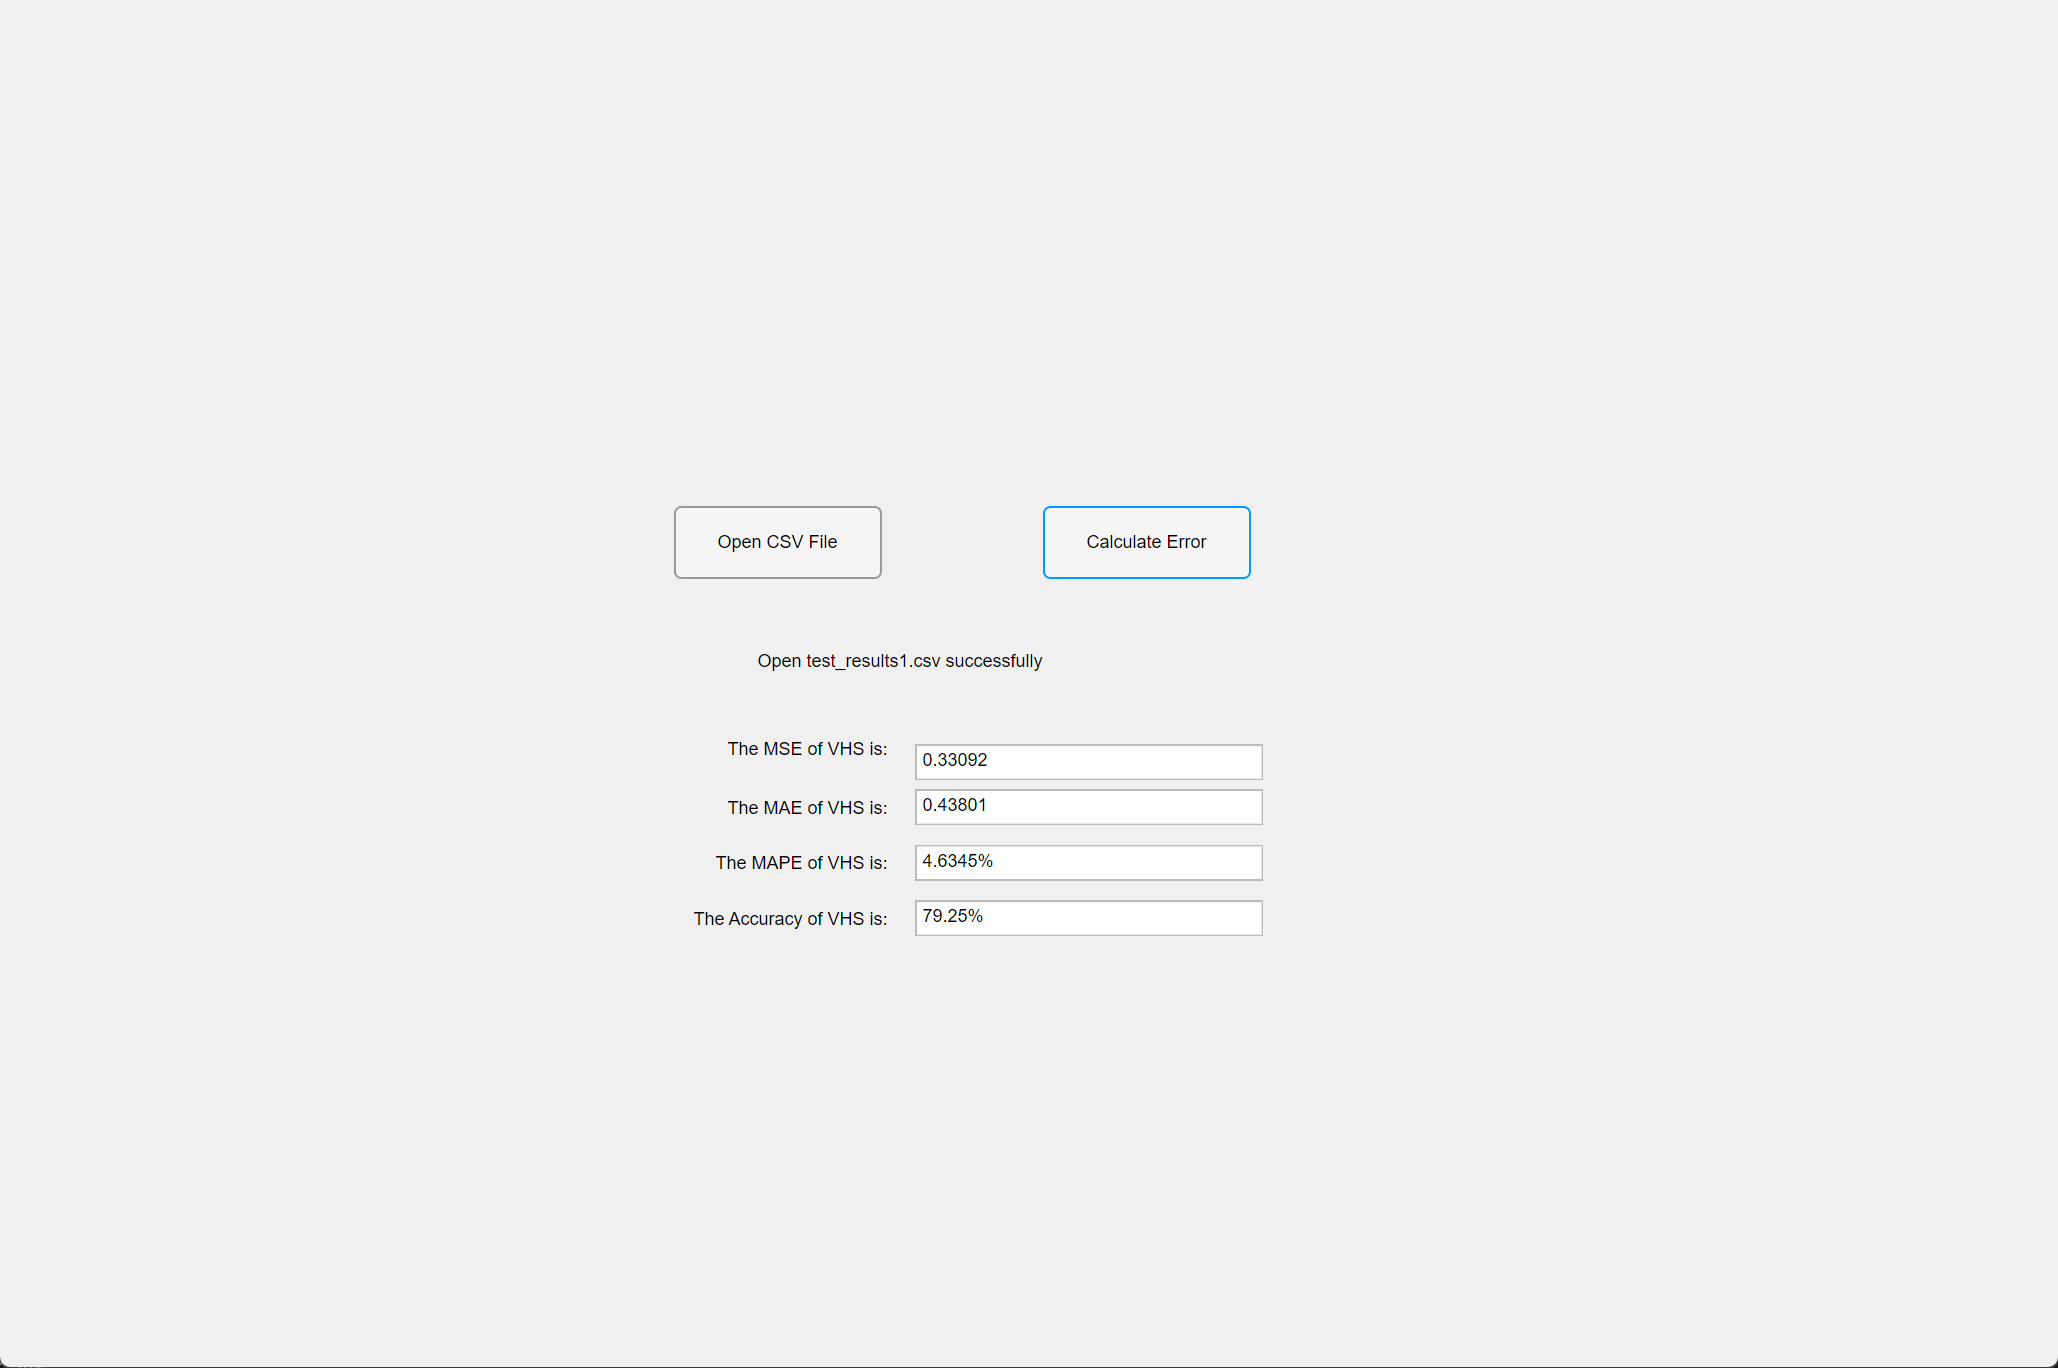

# 5. Show the comprison between predictions and ground truth
## You need to add the title with: image name, predicted VHS and Ground Truth VHS
<p align="center">
  <img src="Com.png" width="60%"> 
</p>


# Please show the comprison results of images: 1420.png, 1479.png and 1530.png from Valid dataset

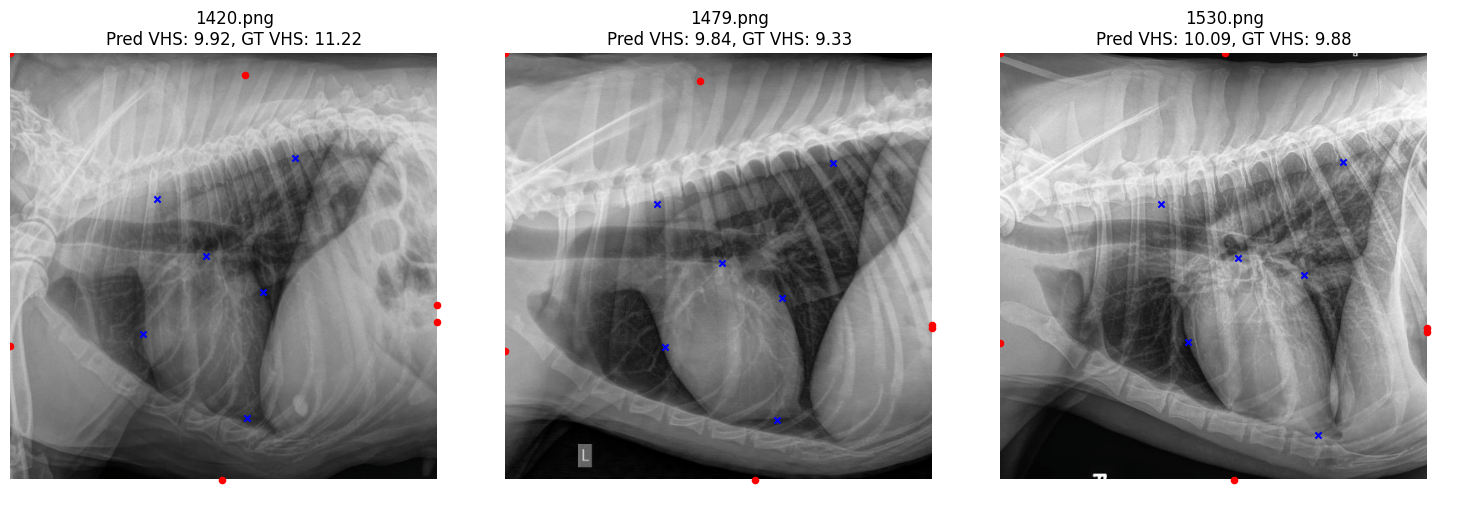

In [85]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

resized_image_size = 512
valid_root = 'C:/Users/76373/OneDrive/Desktop/Valid'

dataset_valid = DogHeartDataset(valid_root, get_transform(resized_image_size))
data_loader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False, collate_fn=custom_collate_fn)

image_names = ["1420.png", "1479.png", "1530.png"]
dataset_filenames = [img_name for img_name in dataset_valid.imgs]
image_indices = [dataset_filenames.index(name) if name in dataset_filenames else None for name in image_names]

plt.figure(figsize=(15, 5))
for i, (idx, image_name) in enumerate(zip(image_indices, image_names)):
    if idx is not None:
        
        img, gt_points, gt_vhs = dataset_valid[idx]
        img = img.to("cuda")

        with torch.no_grad():
            
            pred_points = model(img.unsqueeze(0)).squeeze(0).cpu().view(-1, 2)
            
            pred_points = torch.clamp(pred_points, 0.0, 1.0)

            pred_vhs = calculate_vhs(pred_points.view(1, 6, 2)).item()

            H, W = img.shape[1], img.shape[2]  
            pixel_pred_points = pred_points.clone()
            pixel_pred_points[:, 0] *= W  
            pixel_pred_points[:, 1] *= H  

            gt_points = gt_points.view(-1, 2).cpu()
            pixel_gt_points = gt_points.clone()
            pixel_gt_points[:, 0] *= H
            pixel_gt_points[:, 1] *= H

            true_vhs = gt_vhs.item()

        img_cpu = img.cpu().permute(1, 2, 0).numpy()
        img_cpu = img_cpu * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img_cpu = img_cpu.clip(0, 1)

        plt.subplot(1, 3, i + 1)
        plt.imshow(img_cpu)
        for p in pixel_pred_points:
            plt.scatter(p[0].item(), p[1].item(), s=20, c='red')
        for q in pixel_gt_points:
            plt.scatter(q[0].item(), q[1].item(), s=20, c='blue', marker='x')

        plt.title(f"{image_name}\nPred VHS: {pred_vhs:.2f}, GT VHS: {true_vhs:.2f}")
        plt.axis('off')
    else:
        print(f"{image_name} not found in dataset.")

plt.tight_layout()
plt.savefig("Com.png")
plt.show()


# 6. Write a three-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.


https://www.researchgate.net/publication/390668042_A_Neural_Network-Based_Method_for_Dog_Heart_VHS_Assessment

# 7. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file, prediction CSV file and add paper link)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points

# 8. Bonus points (10 points if your accuracy is higer than 87.3%)